In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.utils.data import Dataset, DataLoader
import torch
import random
import math
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse-251-b-2025/train.npz
/kaggle/input/cse-251-b-2025/test_input.npz


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # for single-GPU
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')
# train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')
# test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


# TrajectoryDataset Class

In [4]:
class TrajectoryDataset(Dataset):
    def __init__(self, data_tensor, isTest) :
        """
        Args:
            data_tensor: Tensor of shape (num_scenes, num_agents, timesteps, features)
                         Expected to be (10000, 50, 110, 6)
        """
        self.data = torch.tensor(data_tensor)
        self.num_scenes = data_tensor.shape[0]
        self.num_agents = data_tensor.shape[1]
        self.timesteps = data_tensor.shape[2]
        self.isTest = isTest
        self.train = False
        # Validate input shape
        if len(data_tensor.shape) != 4 or data_tensor.shape[3] != 6:
            raise ValueError("Input tensor must have shape (scenes, agents, timesteps, 6 features)")
    
    def __len__(self):
        return self.num_scenes
    
    def __getitem__(self, idx):
        scene_tensor = self.data[idx].clone()
        
        yaw = scene_tensor[0, 0, 4]
        rot_mat = torch.tensor([
            [torch.cos(-yaw), -torch.sin(-yaw)],
            [torch.sin(-yaw),  torch.cos(-yaw)]
        ])
        
        # add slight noise to tolerate noisy
        # max_theta_deg = 15
        # if np.random.rand() < 0.5:
        #     theta = np.radians(np.random.uniform(-max_theta_deg, max_theta_deg))
        #     noise_rot = torch.tensor([
        #         [math.cos(theta), -math.sin(theta)],
        #         [math.sin(theta),  math.cos(theta)]
        #     ], dtype=rot_mat.dtype, device=rot_mat.device)
        #     rot_mat = noise_rot @ rot_mat 
            
        ego_pos = scene_tensor[0, :, :2]
        roted_ego_pos = scene_tensor[0, :, :2] @ rot_mat.T # (110,2)
        roted_ego_vel = scene_tensor[0, :, 2:4] @ rot_mat.T # (110,2)
        ego_yaw = scene_tensor[0, :, 4] # (110, )
        
        # rotated ego positions difference features (falttened at last)
        roted_ego_pos_diff = roted_ego_pos[1:] - roted_ego_pos[:-1] # (109,2)
        if not self.isTest:
            roted_ego_pos_diff_init  = roted_ego_pos_diff[:-60]  # (49,2)
            roted_ego_pos_diff_target = roted_ego_pos_diff[-60:] #  (60,2)
        else:
            roted_ego_pos_diff_init = roted_ego_pos_diff
        roted_ego_pos_diff_window = roted_ego_pos_diff_init.reshape(1,-1) # (1, 98), row-major order flatten
        ### Train data-only data transformations (regularization)
        # if not self.isTest and self.train:
        #     roted_ego_pos_diff_window += torch.normal(mean=0, std=0.05, size=roted_ego_pos_diff_window.shape)

        # rotated ego velocity difference features (falttened at last)
        roted_ego_vel_diff = roted_ego_vel[1:] - roted_ego_vel[:-1] # (109,2)
        if not self.isTest:
            roted_ego_vel_diff_init = roted_ego_vel_diff[:-60] # (49,2)
            roted_ego_vel_diff_target = roted_ego_vel_diff[-60:] # (60,2)
        else:
            roted_ego_vel_diff_init = roted_ego_vel_diff
        roted_ego_vel_diff_window = roted_ego_vel_diff_init.reshape(1,-1) # (1, 98), row-major order flatten

        # ego yaw angle difference features 
        ego_yaw_diff = ego_yaw[1:] - ego_yaw[:-1] # (109,)
        if not self.isTest:
            ego_yaw_diff_init = ego_yaw_diff[:-60]  # (49,)
            ego_yaw_diff_target = ego_yaw_diff[-60:] # (60,)
        else:
            ego_yaw_diff_init = ego_yaw_diff
        ego_yaw_diff_window = ego_yaw_diff_init.reshape(1,-1) # (1, 49), row-major order flatten

        ### final feature vector
        feature = torch.cat([roted_ego_pos_diff_window, roted_ego_vel_diff_window, ego_yaw_diff_window], dim=1) # (1,245)
        
        # reverse transformation of prediction and targets
        recovery_angle_mat = rot_mat
        if not self.isTest:
            recovery_pos_roted = roted_ego_pos[-61] # (2,)
            label_pos = ego_pos[-60:] # (60,2)
            return (
                feature.float(), # (1,245)
                recovery_pos_roted.float(), # (2)
                recovery_angle_mat.float(), # (2,2)
                label_pos.float(), # (60,2)
                roted_ego_pos_diff_target.float(), # (60,2)
                roted_ego_vel_diff_target.float(), # (60,2)
                ego_yaw_diff_target.unsqueeze(1).float() # (60,1)
            )
        else: 
            recovery_pos_roted = roted_ego_pos[-1] # (2,)
            return (
                feature.float(), # (1,245)
                recovery_pos_roted.float(), # (2)
                recovery_angle_mat.float(), # (2,2)
            )
        
feature_size = 2*49 + 2*49 + 49
output_size = 2 + 2 + 1
dataset = TrajectoryDataset(train_data, isTest=False)
for tensor in dataset[1]: print(tensor.shape)

torch.Size([1, 245])
torch.Size([2])
torch.Size([2, 2])
torch.Size([60, 2])
torch.Size([60, 2])
torch.Size([60, 2])
torch.Size([60, 1])


# Create datasets and dataloaders, set device

In [5]:
from torch.utils.data import random_split

batch_size = 128
train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.9), int(len(dataset)*0.1)])
train_dataset.train = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader))

for batch in train_loader:
    print([x.shape for x in batch])
    break  # only the first batch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

71
[torch.Size([128, 1, 245]), torch.Size([128, 2]), torch.Size([128, 2, 2]), torch.Size([128, 60, 2]), torch.Size([128, 60, 2]), torch.Size([128, 60, 2]), torch.Size([128, 60, 1])]


device(type='cuda')

# Model architecture

In [6]:
import torch.nn as nn

class OneStepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        """
        LSTM for one-step-ahead prediction
        
        Args:
            input_size: number of input features (104)
            hidden_size: number of LSTM hidden units
            output_size: number of output features (2)
            num_layers: number of LSTM layers
        """
        super(OneStepLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.fc_in = nn.Linear(input_size, input_size)
        self.ln_in = nn.LayerNorm(input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_out= nn.Linear(hidden_size, output_size)
        self.init_h = nn.Parameter(torch.zeros(num_layers, hidden_size))
        self.init_c = nn.Parameter(torch.zeros(num_layers, hidden_size))
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(hidden_size)
        
    def forward(self, x, h0=None, c0=None):
        # x shape: (input_len, seq_length=110, input_size=104)
        batch_size = x.size(0)
        if h0==None:
            h0 = self.init_h.unsqueeze(1).expand(-1, batch_size, -1).contiguous() # (num_layers, N, H_out)
        if c0==None:
            c0 = self.init_c.unsqueeze(1).expand(-1, batch_size, -1).contiguous() # (num_layers, N, H_out)

        out = self.fc_in(x)
        out = self.ln_in(out)
        out = self.dropout(out)
        out, (h_n, c_n) = self.lstm(out, (h0, c0)) # (N, L, H_out), (num_layers, N, H_out), (num_layers, N, H_out)
        out = self.ln(out)
        out = self.dropout(out)
        predictions = self.fc_out(out) # # (N, L, 6)
        
        return predictions, h_n, c_n

# Training Loop

In [7]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from copy import deepcopy

def predict(model, inputs:tuple, criterion, isTest:bool):
    if isTest:
        feature, recovery_pos_roted, recovery_angle_mat = [x.to(device) for x in inputs]
    else:
        feature, recovery_pos_roted, recovery_angle_mat, label_pos, roted_pos_diff_target, roted_vel_diff_target, yaw_diff_target = [x.to(device) for x in inputs]
    
    roted_ego_pos_diff_window = feature[:,0,:98]
    
    roted_pos_diff_pred, roted_vel_diff_pred, yaw_diff_pred = [], [], []    
    h = c = None
    for t in range(60):
        # The first 2 nums are roted_pos_diff_pred, second 2 nums are roted_vel_diff_pred, 5th num is yaw_diff_pred 
        output, h, c = model(feature, h, c) # (batch_size, 1, output_size)
        rpd, rvd, yd = output[:,:,:2], output[:,:,2:4], output[:,:,[4]] # (batch_size, 1, 2), # (batch_size, 1, 2), # (batch_size, 1, 1)
        roted_pos_diff_pred.append(rpd)
        roted_vel_diff_pred.append(rvd)
        yaw_diff_pred.append(yd)
        feature = torch.cat([feature[:,:,2:98], rpd, feature[:,:,98+2:98+98], rvd, feature[:,:,98+98+1:], yd], dim=-1)  # 滚动窗口
    
    roted_pos_diff_pred = torch.cat(roted_pos_diff_pred, dim=1) # (batch_size, 60, 2)
    if model.training==False:
        for idx_in_batch, scene in enumerate(roted_ego_pos_diff_window):
            first_movements_sum = torch.sum(torch.abs(scene))
            if first_movements_sum < 1:
                roted_pos_diff_pred[idx_in_batch] = torch.zeros((60, 2), device=device)
    roted_vel_diff_pred = torch.cat(roted_vel_diff_pred, dim=1) # (batch_size, 60, 2)
    yaw_diff_pred = torch.cat(yaw_diff_pred, dim=1) # (batch_size, 60, 2)

    if not isTest:
        loss_pos = criterion(roted_pos_diff_pred, roted_pos_diff_target)
        loss_vel = criterion(roted_vel_diff_pred, roted_vel_diff_target)
        loss_yaw = criterion(yaw_diff_pred, yaw_diff_target)
    
    ###### All teacher forcing
    # batch_pred_pos_diff, _, _ = model(batch_X)  # shape: [64, 109, 6]
    # batch_pred_pos = batch_pred_pos_diff + batch_recovery_pos
    # loss = criterion(batch_pred_pos, batch_label_pos)
    ######
    
    # compute original loss after reverse-transform
    roted_pos_diff_pred[:,0,:] += recovery_pos_roted # (batch_size, 2)
    roted_pos_pred = roted_pos_diff_pred.cumsum(dim=1) 
    pos_pred = roted_pos_pred @ recovery_angle_mat
    if not isTest:
        loss_pos_original = criterion(pos_pred, label_pos)

    if not isTest:
        return loss_pos, loss_vel, loss_yaw, loss_pos_original
    else:
        return pos_pred

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1: 100%|██████████| 79/79 [00:17<00:00,  4.59it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 1/100, LR: [0.001] | Train Loss: 1.0180, 82.3252 | Val Loss: 0.1920, 25.2260


Epoch 2: 100%|██████████| 79/79 [00:16<00:00,  4.88it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 2/100, LR: [0.001] | Train Loss: 0.3203, 21.6168 | Val Loss: 0.0880, 16.1135


Epoch 3: 100%|██████████| 79/79 [00:16<00:00,  4.86it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 3/100, LR: [0.001] | Train Loss: 0.2278, 17.5386 | Val Loss: 0.0632, 13.5971


Epoch 4: 100%|██████████| 79/79 [00:16<00:00,  4.75it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 4/100, LR: [0.001] | Train Loss: 0.1782, 15.2747 | Val Loss: 0.0601, 14.6139


Epoch 5: 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 5/100, LR: [0.001] | Train Loss: 0.1428, 13.4188 | Val Loss: 0.0523, 16.1272


Epoch 6: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 6/100, LR: [0.001] | Train Loss: 0.1241, 12.7242 | Val Loss: 0.0459, 11.5715


Epoch 7: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 7/100, LR: [0.001] | Train Loss: 0.1074, 11.7187 | Val Loss: 0.0457, 14.5052


Epoch 8: 100%|██████████| 79/79 [00:16<00:00,  4.75it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 8/100, LR: [0.001] | Train Loss: 0.0959, 11.4163 | Val Loss: 0.0369, 11.9281


Epoch 9: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 9/100, LR: [0.001] | Train Loss: 0.0892, 10.6928 | Val Loss: 0.0372, 10.6084


Epoch 10: 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 10/100, LR: [0.001] | Train Loss: 0.0810, 10.1582 | Val Loss: 0.0377, 10.8346


Epoch 11: 100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 11/100, LR: [0.001] | Train Loss: 0.0745, 10.2034 | Val Loss: 0.0354, 10.0238


Epoch 12: 100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 12/100, LR: [0.001] | Train Loss: 0.0689, 9.9663 | Val Loss: 0.0337, 10.5914


Epoch 13: 100%|██████████| 79/79 [00:16<00:00,  4.80it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 13/100, LR: [0.001] | Train Loss: 0.0660, 9.8664 | Val Loss: 0.0308, 9.9049


Epoch 14: 100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 14/100, LR: [0.001] | Train Loss: 0.0607, 9.4754 | Val Loss: 0.0321, 10.6686


Epoch 15: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 15/100, LR: [0.001] | Train Loss: 0.0587, 9.4796 | Val Loss: 0.0304, 9.3631


Epoch 16: 100%|██████████| 79/79 [00:16<00:00,  4.70it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 16/100, LR: [0.001] | Train Loss: 0.0538, 9.1589 | Val Loss: 0.0304, 10.5089


Epoch 17: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 17/100, LR: [0.001] | Train Loss: 0.0530, 9.0142 | Val Loss: 0.0319, 11.0994


Epoch 18: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 18/100, LR: [0.001] | Train Loss: 0.0511, 9.1077 | Val Loss: 0.0304, 9.8896


Epoch 19: 100%|██████████| 79/79 [00:16<00:00,  4.67it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 19/100, LR: [0.001] | Train Loss: 0.0504, 9.0794 | Val Loss: 0.0343, 9.6446


Epoch 20: 100%|██████████| 79/79 [00:16<00:00,  4.67it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 20/100, LR: [0.00015] | Train Loss: 0.0477, 8.8238 | Val Loss: 0.0281, 9.9744


Epoch 21: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 21/100, LR: [0.00015] | Train Loss: 0.0436, 8.0522 | Val Loss: 0.0258, 8.8680


Epoch 22: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 22/100, LR: [0.00015] | Train Loss: 0.0430, 7.7612 | Val Loss: 0.0256, 8.5418


Epoch 23: 100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 23/100, LR: [0.00015] | Train Loss: 0.0426, 7.9432 | Val Loss: 0.0252, 8.5325


Epoch 24: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 24/100, LR: [0.00015] | Train Loss: 0.0422, 7.7409 | Val Loss: 0.0244, 8.2765


Epoch 25: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 25/100, LR: [0.00015] | Train Loss: 0.0414, 7.6575 | Val Loss: 0.0244, 8.3712


Epoch 26: 100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 26/100, LR: [0.00015] | Train Loss: 0.0411, 7.7189 | Val Loss: 0.0249, 8.4169


Epoch 27: 100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 27/100, LR: [0.00015] | Train Loss: 0.0407, 7.6612 | Val Loss: 0.0250, 8.5305


Epoch 28: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 28/100, LR: [0.00015] | Train Loss: 0.0399, 7.6021 | Val Loss: 0.0239, 8.2465


Epoch 29: 100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 29/100, LR: [0.00015] | Train Loss: 0.0402, 7.5999 | Val Loss: 0.0252, 8.5731


Epoch 30: 100%|██████████| 79/79 [00:16<00:00,  4.74it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 30/100, LR: [0.00015] | Train Loss: 0.0399, 7.8132 | Val Loss: 0.0247, 8.4515


Epoch 31: 100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 31/100, LR: [0.00015] | Train Loss: 0.0393, 7.6345 | Val Loss: 0.0241, 8.3966


Epoch 32: 100%|██████████| 79/79 [00:16<00:00,  4.81it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 32/100, LR: [0.00015] | Train Loss: 0.0392, 7.6331 | Val Loss: 0.0238, 8.4135


Epoch 33: 100%|██████████| 79/79 [00:16<00:00,  4.86it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 33/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0386, 7.5719 | Val Loss: 0.0241, 8.2842


Epoch 34: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 34/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0384, 7.3362 | Val Loss: 0.0232, 7.9749


Epoch 35: 100%|██████████| 79/79 [00:16<00:00,  4.65it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 35/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0381, 7.2888 | Val Loss: 0.0235, 8.0267


Epoch 36: 100%|██████████| 79/79 [00:16<00:00,  4.74it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 36/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0379, 7.3613 | Val Loss: 0.0234, 8.2319


Epoch 37: 100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 37/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0376, 7.2422 | Val Loss: 0.0229, 7.9683


Epoch 38: 100%|██████████| 79/79 [00:16<00:00,  4.66it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 38/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0373, 7.2014 | Val Loss: 0.0234, 8.1353


Epoch 39: 100%|██████████| 79/79 [00:16<00:00,  4.67it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 39/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0371, 7.1853 | Val Loss: 0.0234, 8.2235


Epoch 40: 100%|██████████| 79/79 [00:16<00:00,  4.70it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 40/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0376, 7.2736 | Val Loss: 0.0229, 7.8968


Epoch 41: 100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 41/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0375, 7.2682 | Val Loss: 0.0230, 7.9418


Epoch 42: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 42/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0371, 7.2459 | Val Loss: 0.0229, 7.9329


Epoch 43: 100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 43/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0372, 7.3358 | Val Loss: 0.0229, 8.0908


Epoch 44: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 44/100, LR: [2.2499999999999998e-05] | Train Loss: 0.0370, 7.2676 | Val Loss: 0.0229, 8.0092


Epoch 45: 100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 45/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.2027 | Val Loss: 0.0228, 7.9066


Epoch 46: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 46/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0366, 7.2004 | Val Loss: 0.0228, 7.9233


Epoch 47: 100%|██████████| 79/79 [00:16<00:00,  4.74it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 47/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0365, 7.1266 | Val Loss: 0.0229, 7.8969


Epoch 48: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 48/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.2281 | Val Loss: 0.0228, 7.8940


Epoch 49: 100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 49/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.1314 | Val Loss: 0.0228, 7.8715


Epoch 50: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 50/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.1754 | Val Loss: 0.0229, 7.9865


Epoch 51: 100%|██████████| 79/79 [00:16<00:00,  4.68it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 51/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.1299 | Val Loss: 0.0229, 7.9022


Epoch 52: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 52/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0368, 7.1447 | Val Loss: 0.0228, 7.8514


Epoch 53: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 53/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0368, 7.1689 | Val Loss: 0.0228, 7.8405


Epoch 54: 100%|██████████| 79/79 [00:16<00:00,  4.68it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 54/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.1614 | Val Loss: 0.0230, 7.9341


Epoch 55: 100%|██████████| 79/79 [00:16<00:00,  4.67it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 55/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.1213 | Val Loss: 0.0227, 7.8374


Epoch 56: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 56/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0368, 7.1753 | Val Loss: 0.0228, 7.8902


Epoch 57: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 57/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0366, 7.1077 | Val Loss: 0.0228, 7.8452


Epoch 58: 100%|██████████| 79/79 [00:17<00:00,  4.64it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 58/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0366, 7.1437 | Val Loss: 0.0226, 7.8080


Epoch 59: 100%|██████████| 79/79 [00:17<00:00,  4.58it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 59/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0366, 7.1193 | Val Loss: 0.0228, 7.8636


Epoch 60: 100%|██████████| 79/79 [00:17<00:00,  4.63it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 60/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0367, 7.2052 | Val Loss: 0.0228, 7.9666


Epoch 61: 100%|██████████| 79/79 [00:17<00:00,  4.62it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 61/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0366, 7.1515 | Val Loss: 0.0228, 7.9533


Epoch 62: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 62/100, LR: [3.3749999999999995e-06] | Train Loss: 0.0365, 7.1265 | Val Loss: 0.0227, 7.8259


Epoch 63: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 63/100, LR: [5.062499999999999e-07] | Train Loss: 0.0366, 7.1554 | Val Loss: 0.0228, 7.9061


Epoch 64: 100%|██████████| 79/79 [00:17<00:00,  4.62it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 64/100, LR: [5.062499999999999e-07] | Train Loss: 0.0363, 7.0394 | Val Loss: 0.0228, 7.8829


Epoch 65: 100%|██████████| 79/79 [00:17<00:00,  4.58it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 65/100, LR: [5.062499999999999e-07] | Train Loss: 0.0366, 7.2249 | Val Loss: 0.0227, 7.8699


Epoch 66: 100%|██████████| 79/79 [00:17<00:00,  4.64it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 66/100, LR: [5.062499999999999e-07] | Train Loss: 0.0365, 7.1494 | Val Loss: 0.0226, 7.8245


Epoch 67: 100%|██████████| 79/79 [00:17<00:00,  4.61it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 67/100, LR: [5.062499999999999e-07] | Train Loss: 0.0365, 7.1229 | Val Loss: 0.0228, 7.8954


Epoch 68: 100%|██████████| 79/79 [00:17<00:00,  4.61it/s]


Using all 10000 samples for training, so this isn't really hold-out validation set
Epoch 68/100, LR: [7.593749999999999e-08] | Train Loss: 0.0364, 7.0449 | Val Loss: 0.0226, 7.8400
training finished, best val loss = 7.808046318307707


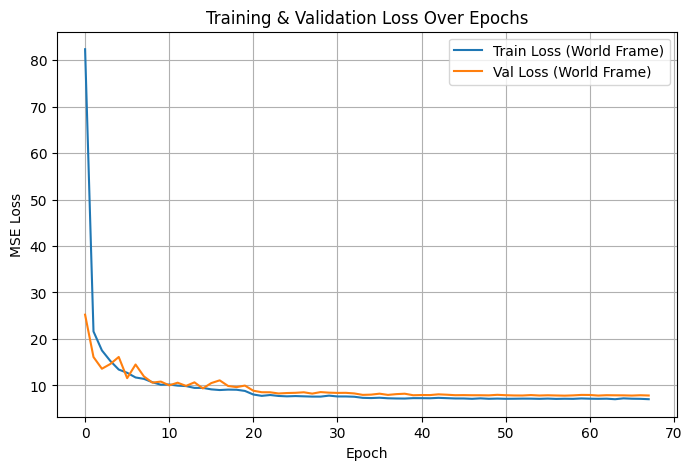

In [8]:
criterion = nn.MSELoss(reduction='mean')  # For regression task
def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler):
 
    train_loss_list = []
    val_loss_list = []

    model.to(device)
    best_loss = np.inf
    best_model = None
    patience = 10
    isTest = False
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_loss_original = 0.0
        train_loader = train_val_loader    
        if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") == "Batch":
            train_loader = train_val_loader
        for inputs in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            optimizer.zero_grad()
            loss_pos, loss_vel, loss_yaw, loss_pos_original = predict(model, inputs, criterion, isTest)
            (loss_pos_original+loss_vel+loss_yaw).backward()
            optimizer.step()
            train_loss += loss_pos.item() # MSE doesn't average but sums when the reduction is 'sum'
            train_loss_original += loss_pos_original.item()
        train_loss /= len(train_loader)
        train_loss_original /= len(train_loader)
        train_loss_list.append(train_loss_original)
        
        # Validation phase (50-109 autoregressive)
        model.eval()
        val_loss = 0.0
        val_loss_original = 0.0
        if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") == "Batch":
            print("Using all 10000 samples for training, so this isn't really hold-out validation set")
            val_loader = train_val_loader
        with torch.no_grad():
            for inputs in val_loader:
                loss_pos, loss_vel, loss_yaw, loss_pos_original = predict(model, inputs, criterion, isTest)
                val_loss += loss_pos.item()
                val_loss_original += loss_pos_original.item()
        val_loss /= len(val_loader)
        val_loss_original /= len(val_loader)
        val_loss_list.append(val_loss_original)
        scheduler.step(val_loss_original)

        print(f'Epoch {epoch+1}/{epochs}, LR: {scheduler.get_last_lr()} | Train Loss: {train_loss:.4f}, {train_loss_original:.4f} | Val Loss: {val_loss:.4f}, {val_loss_original:.4f}')

        if val_loss_original < best_loss:
            best_loss = val_loss_original
            best_model = deepcopy(model)
            patience = 10
        else:
            patience -= 1
            if patience <= 0:
                break
    
    return best_loss, best_model, train_loss_list, val_loss_list
    
model = OneStepLSTM(input_size=feature_size, hidden_size=256, output_size=output_size, num_layers=2, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.15, patience=4, verbose=True)
best_loss, model, train_loss_list, val_loss_list = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=100, optimizer=optimizer, scheduler=scheduler)
print('training finished, best val loss =', best_loss)

plt.figure(figsize=(8,5))
plt.plot(train_loss_list, label="Train Loss (World Frame)")
plt.plot(val_loss_list, label="Val Loss (World Frame)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# raise ValueError("Stop here")

# Generate predictions for a few scenes and visualize 

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# make gif out of a scene.
def make_gif(data_matrix, data_matrix_2, name, isTest):
   cmap = plt.cm.get_cmap('viridis', 50)
   fig, ax = plt.subplots(figsize=(10, 10))
   # Function to update plot for each frame
   def update(frame):
       ax.clear()
       if frame<50 or isTest==False:
           ax.plot(data_matrix[:frame, 0], data_matrix[:frame, 1], color='tab:orange', label='Ego Vehicle')
           ax.scatter(data_matrix[frame, 0], data_matrix[frame, 1], s=80, color='tab:orange')
       if frame>=50:
           frame_2 = frame-50
           ax.plot(data_matrix_2[:frame_2, 0], data_matrix_2[:frame_2, 1], color='tab:blue', label='Predicted Ego Vehicle')
           ax.scatter(data_matrix_2[frame_2, 0], data_matrix_2[frame_2, 1], s=80, color='tab:blue')
       # Set title with timestep
       ax.set_title(f"{'Test data,' if isTest else 'Train data,'}, Scene {name} Timestep {frame}")
       # Set consistent axis limits
       ax.set_xlim(min(data_matrix[:,0].min(),data_matrix_2[:,0].min()) - 10, max(data_matrix[:,0].max(), data_matrix_2[:,0].max()) + 10)
       ax.set_ylim(min(data_matrix[:,1].min(),data_matrix_2[:,1].min()) - 10, max(data_matrix[:,1].max(), data_matrix_2[:,1].max()) + 10)
       ax.legend()

       return ax.collections + ax.lines

   # Create animation
   anim = animation.FuncAnimation(fig, update, frames=list(range(0, 109, 3)),
                               interval=100, blit=True)
   # Save as GIF
   anim.save(f"trajectory_visualization_{'Test data,' if isTest else 'Train data,'}_{scene_idx}.gif", writer='pillow')
   plt.close()

In [11]:
import os 
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") != "Batch":
    dataset = TrajectoryDatasetTrain(train_data)
    for scene_idx in range(20):
        roted_ego_poses_diff_window, recovery_pose_roted, recovery_angle_mat, label_poses, _ = dataset[scene_idx] # (1,98), (2,), (2,2)
        full_traj = train_data[scene_idx,0,:,:2]
        
        roted_ego_poses_diff_window = roted_ego_poses_diff_window.to(device).unsqueeze(0) # add batch dimension since batch_first=True
        recovery_pose_roted, recovery_angle_mat = recovery_pose_roted.to(device), recovery_angle_mat.to(device) # (batch_size, 2), # (batch_size, 60, 2)

        last_movements_sum = torch.sum(torch.abs(roted_ego_poses_diff_window[0,0,-2*5:]))
        last_avg_acceleration = (roted_ego_poses_diff_window[0,0,-1] - roted_ego_poses_diff_window[0,0,-2*5]) / 9
        print(f'last_movements_sum for scene {scene_idx}: {last_movements_sum} ')
        print(f'last_avg_acceleration for scene {scene_idx}: {last_avg_acceleration} ')
        
        if last_movements_sum < 1.2:
            roted_pos_diff_pred = torch.zeros((roted_ego_poses_diff_window.shape[0], 60, 2), device=device)
        else:
            roted_pos_diff_pred = []    
            h = c = None
            for t in range(60):
                output, h, c = model(roted_ego_poses_diff_window, h, c)
                roted_pos_diff_pred.append(output) # (batch_size, 1, 2)
                roted_ego_poses_diff_window = torch.cat([roted_ego_poses_diff_window[:,:,2:], output], dim=-1)  # 滚动窗口
            roted_pos_diff_pred = torch.cat(roted_pos_diff_pred, dim=1) # (batch_size, 60, 2)
        
        roted_pos_diff_pred[:,0,:] += recovery_pose_roted # (batch_size, 2)
        roted_pos_pred = roted_pos_diff_pred.cumsum(dim=1) 
        traj_pred = roted_pos_pred.squeeze(0) @ recovery_angle_mat
        # print(traj_pred)
        # print(full_traj)
        make_gif(full_traj, traj_pred.cpu().detach().numpy(), name=f'index {scene_idx}', isTest=False)    

# Test and write to submission.csv

In [12]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") != "Batch":
    dataset = TrajectoryDatasetTest(test_data)
    for scene_idx in range(20):
        roted_ego_poses_diff_window, recovery_pose_roted, recovery_angle_mat = dataset[scene_idx] # (1,98), (2,), (2,2)
        full_traj = test_data[scene_idx,0,:,:2]
        
        roted_ego_poses_diff_window = roted_ego_poses_diff_window.to(device).unsqueeze(0) # add batch dimension since batch_first=True
        recovery_pose_roted, recovery_angle_mat = recovery_pose_roted.to(device), recovery_angle_mat.to(device) # (batch_size, 2), # (batch_size, 60, 2)

        last_movements_sum = torch.sum(torch.abs(roted_ego_poses_diff_window[0,0,-2*5:]))
        last_avg_acceleration = (roted_ego_poses_diff_window[0,0,-1] - roted_ego_poses_diff_window[0,0,-2*5]) / 9
        print(f'last_movements_sum for scene {scene_idx}: {last_movements_sum} ')
        print(f'last_avg_acceleration for scene {scene_idx}: {last_avg_acceleration} ')
        
        if last_movements_sum < 1.2:
            roted_pos_diff_pred = torch.zeros((roted_ego_poses_diff_window.shape[0], 60, 2), device=device)
        else:
            roted_pos_diff_pred = []    
            h = c = None
            for t in range(60):
                output, h, c = model(roted_ego_poses_diff_window, h, c)
                roted_pos_diff_pred.append(output) # (batch_size, 1, 2)
                roted_ego_poses_diff_window = torch.cat([roted_ego_poses_diff_window[:,:,2:], output], dim=-1)  # 滚动窗口
            roted_pos_diff_pred = torch.cat(roted_pos_diff_pred, dim=1) # (batch_size, 60, 2)
            
        roted_pos_diff_pred[:,0,:] += recovery_pose_roted # (batch_size, 2)
        roted_pos_pred = roted_pos_diff_pred.cumsum(dim=1) 
        traj_pred = roted_pos_pred.squeeze(0) @ recovery_angle_mat
        # print(traj_pred)
        # print(full_traj)
        make_gif(full_traj, traj_pred.cpu().detach().numpy(), name=f'test scene {scene_idx}', isTest=True)    

In [13]:
isTest = True
dataset = TrajectoryDataset(test_data, isTest=isTest)
for tensor in dataset[1]: print(tensor.shape)
test_loader = DataLoader(dataset, batch_size=128, shuffle=False)

model.eval()
with torch.no_grad():
    all_scene_preds = []
    for inputs in test_loader:
        pos_pred = predict(model, inputs, criterion, isTest)
        all_scene_preds.append(pos_pred)
        
all_scene_preds = torch.cat(all_scene_preds,dim=0).reshape(-1,2)
import pandas as pd
output_df = pd.DataFrame(all_scene_preds.cpu().numpy(), columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv')

torch.Size([1, 245])
torch.Size([2])
torch.Size([2, 2])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(
